# 4 Degree of Freedom Robot Arm

In [1]:
import time
import numpy as np
from sympy import *
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from IPython.display import display, Math

from tools import *

## Variables and settings

In [2]:
# Constants
l0 = symbols('l_0')
l2 = symbols('l_2')
l3 = symbols('l_3')
l4 = symbols('l_4')
le = symbols('l_e')
l0_val = 5
l2_val = 20
l3_val = 15
l4_val = 5
le_val = 3

# Variables
theta2 = symbols(r"\theta_2")
theta3 = symbols(r"\theta_3")
theta4 = symbols(r"\theta_4")
d1 = symbols('d_1')

alias = {}

# display cos(theta) as c\theta, sin(theta) as s\theta
alias.update({sin(theta2): symbols(r"s\theta_2"),
              cos(theta2): symbols(r"c\theta_2"),
              sin(theta3): symbols(r"s\theta_3"),
              cos(theta3): symbols(r"c\theta_3"),
              sin(theta4): symbols(r"s\theta_4"),
              cos(theta4): symbols(r"c\theta_4")})

## Transformation Metrics (see forward_kinematics.py)

In [3]:
R01, T01 = get_trans_mat(0, 0, l0+d1, 0)
R12, T12 = get_trans_mat(0, 0, 0, theta2)
R23, T23 = get_trans_mat(l2, 90, 0, theta3+pi/2)
R34, T34 = get_trans_mat(0, 90, l3, theta4)
R4e, T4e = get_trans_mat(-le, 0, l4, 0)

T04 = T01 * T12 * T23 * T34
T0e = T04 * T4e

## Inverse Kinematics to find $\theta$ values from the position metrices

In [4]:
def get_random_trans_mat():
    """
    Obtain random position metrices by applying forward kinematics using
    randomly assigned theta2, theta3, theta4 & d1 values.
    Random assignment is for proving concepts and is practically useless.
    """
    theta2_val = (np.random.rand()*360-180)/180*np.pi
    theta3_val = (np.random.rand()*300-150)/180*np.pi
    theta4_val = (np.random.rand()*360-180)/180*np.pi
    d1_val = np.random.rand() * 40

    values = {l0: l0_val, l2: l2_val, l3: l3_val, l4: l4_val, le: le_val, 
              theta2: theta2_val, theta3: theta3_val, theta4: theta4_val, 
              d1: d1_val}
    T0e_target = T0e.subs(values)
    # convert infinitely small non-zero float to zero
    T0e_target = np.array(T0e_target, dtype=np.float32)
    T0e_target[np.abs(T0e_target) < 1e-7] = 0
    
    return T0e_target

In [5]:
def solve_inverse_kinematics(vals_target, show_ans=False):
    # ========================= d1 ==============================
    d1_inv =le*r31 - l4*r33 + Z - l0 - l3*r33
    d1_ans = float(d1_inv.subs(vals_target))
    if show_ans:
        eqnprint(d1, alias, None, d1_ans)

    # ========================= theta2 ==========================
    theta2_inv = atan2((le*r21 - r23*(l3+l4) + Y)/l2, (le*r11 - r13*(l3+l4) + X)/l2)
    theta2_ans = float(theta2_inv.subs(vals_target))
    if show_ans:
        eqnprint(theta2, alias, None, theta2_ans)

    # ========================= theta3 ==========================
    if sin(theta2_ans) != 0:
        theta3_inv = atan2(r33, r23/sin(theta2_ans))
    else:
        theta3_inv = atan2(r33, r13/cos(theta2_ans))

    theta3_ans = float(theta3_inv.subs(vals_target))
    # theta3 range from -180 to 180 deg
    if theta3_ans > np.pi:
        theta3_ans -= 2*np.pi 
    if show_ans:
        eqnprint(theta3, alias, None, theta3_ans)

    # ========================= theta4 ==========================
    if theta3_ans == np.pi/2:
        theta4_inv = atan2(r12, -r11) - theta2_ans
    elif theta3_ans == -np.pi/2:
        theta4_inv = atan2(-r12, r11) + theta2_ans
    else:
        theta4_inv = atan2(-r32/cos(theta3_ans), r31/cos(theta3_ans))

    theta4_ans = float(theta4_inv.subs(vals_target))
    # theta4 range from -180 to 180 deg
    if theta4_ans > np.pi:
        theta4_ans -= 2*np.pi 
    if show_ans:
        eqnprint(theta4, alias, None, theta4_ans)
    
    return d1_ans, theta2_ans, theta3_ans, theta4_ans


In [6]:
r11 = symbols('r_{11}')
r12 = symbols('r_{12}')
r13 = symbols('r_{13}')
r21 = symbols('r_{21}')
r22 = symbols('r_{22}')
r23 = symbols('r_{23}')
r31 = symbols('r_{31}')
r32 = symbols('r_{32}')
r33 = symbols('r_{33}')
X = symbols('X')
Y = symbols('Y')
Z = symbols('Z')
empty_vals = {r11: None, r12: None, r13: None, 
              r21: None, r22: None, r23: None, 
              r31: None, r32: None, r33: None, 
              X: None, Y: None, Z: None}

In [33]:
num_via_points = 10

# + 2 because start and end points:
d1_points = np.ndarray(num_via_points + 2)
theta2_points = np.ndarray(num_via_points + 2)
theta3_points = np.ndarray(num_via_points + 2)
theta4_points = np.ndarray(num_via_points + 2)

# XYZ values for target positions:
P_coordinates = np.ndarray([num_via_points + 2, 3])

for i in range(num_via_points + 2):
    P = get_random_trans_mat()
#     print(P[:3, -1])
    P_coordinates[i, :] = P[:3, -1]
    # get rii, X, Y, Z
    vals_target = update_target_vals(P, empty_vals)
    vals_target.update({l0: l0_val, l2: l2_val, l3: l3_val, l4: l4_val, le: le_val})
    if i == 0:
        print('======> Start Position:')
        symprint('P', 0, 'start')
        matprint(Matrix(P))
        show_ans = True
    elif i == num_via_points + 1:
        print('======> End Position:')
        symprint('P', 0, 'start')
        matprint(Matrix(P))
        show_ans = True
    else:
        show_ans = False
        
    # solve theta values
    d1_points[i], theta2_points[i], theta3_points[i], theta4_points[i] = solve_inverse_kinematics(vals_target, show_ans=show_ans)

======> Start Position:


^0P_start

Matrix([
[ 0.843135, -0.522406, 0.127335, -6.63047],
[ 0.451075,   0.81608,  0.36131, -12.9899],
[-0.292667, -0.247196,  0.92371,  40.1803],
[        0,         0,        0,      1.0]])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

======> End Position:


^0P_start

Matrix([
[-0.133582,  -0.982215, 0.131943, -0.57361],
[ 0.695713, 0.00187531, 0.718318, -7.39169],
[ -0.70579,   0.187749, 0.683089,  31.2029],
[        0,          0,        0,      1.0]])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Now we have arrays for each theta, each array has a length of 12, corresponding to 12 points.

Then we need arrays with length 11, corresponding to 11 segments.

In [34]:
# calculate distance between two points position
dist = np.sqrt(np.sum((P_coordinates[1:] - P_coordinates[:-1])**2, axis=1))
# time between two points depending on the distance
tf = dist/20

via_points = d1_points

a_mins = np.ndarray(num_via_points + 2)  # minimum required accelerations
a_vals = np.ndarray(num_via_points + 2)  # actual acclerations
V_vals = np.ndarray(num_via_points + 1)  # velocity for linear regions
t_blends = np.ndarray(num_via_points + 2)  # time for blend regions
t_linears = np.ndarray(num_via_points + 1)  # time for linear regions

a_mins[:-1] = 2 * (via_points[1:] - via_points[:-1]) / (tf/2)**2
a_mins[-1] = a_mins[-2]  # make the last acceleration magnitude = second last 


# Step 1: Find the start and end acceleration:
a_vals[0] = np.sign(via_points[1] - via_points[0]) * np.abs(a_mins[0])
a_vals[-1] = np.sign(via_points[-2] - via_points[-1]) * np.abs(a_mins[-1])

# Step 2: Find the start and end blend times (using a_vals[0] and a_vals[-1]):
t_blends[0] = tf[0] - np.sqrt(tf[0]**2 - 2*(via_points[1]-via_points[0])/a_vals[0])
t_blends[-1] = tf[-1] - np.sqrt(tf[-1]**2 + 2*(via_points[-1]-via_points[-2])/a_vals[-1])

# Step3: Find the start and end velocity (using t_blends[0] and t_blends[-1]):
V_vals[0] = (via_points[1]-via_points[0]) / (tf[0]-0.5*t_blends[0])
V_vals[-1] = (via_points[-1]-via_points[-2]) / (tf[-1]-0.5*t_blends[-1])

# Step 4: Find middle via points velocity at linear regions:
V_vals[1:-1] = (via_points[2:-1] - via_points[1:-2]) / tf[1:-1]

# Step 5: Find middle via points blend acceleration (using V_vals[:]):
a_vals[1:-1] = np.sign(V_vals[1:] - V_vals[:-1]) * np.abs(a_mins[1:-1])

# Step 6: Find middle via points blend times (using V_vals[:] and a_vals[1:-1]):
t_blends[1:-1] = (V_vals[1:] - V_vals[:-1]) / a_vals[1:-1]

# Step 6: Find all times for linear regions (using t_blends[:]):
t_linears[0] = tf[0] - t_blends[0] - 0.5*t_blends[1]
t_linears[-1] = tf[-1] - t_blends[-1] - 0.5*t_blends[-2]
t_linears[1:-1] = tf[1:-1] - 0.5*t_blends[2:-1] - 0.5*t_blends[1:-2]

print('tf', tf)
print('via_points', via_points)
print('a_mins', a_mins)
print('a_vals', a_vals)
print('V_vals', V_vals)
print('t_blends', t_blends)
print('t_linears', t_linears)

tf [1.64514475 1.59194673 1.3127388  3.12558531 3.01768119 1.20725671
 2.5875257  1.18582799 1.31214058 2.72153569 1.98568569]
via_points [15.82814407 38.29624939 17.91276169 33.99390411 13.61974907 34.27577209
 15.20810318 35.65044403 14.82740974 19.12819099 38.48338318 10.42377281]
a_mins [  66.4122518   -64.34449863   74.65351147  -16.68425729   18.14637925
 -104.66183272   24.4259391  -118.46514854   19.98373258   20.9054445
  -56.9312358   -56.9312358 ]
a_vals [  66.4122518   -64.34449863   74.65351147  -16.68425729   18.14637925
 -104.66183272   24.4259391  -118.46514854   19.98373258   20.9054445
  -56.9312358    56.9312358 ]
V_vals [ 14.63776527 -12.80412676  12.25007016  -6.51850869   6.84499843
 -15.79421245   7.90034313 -17.5599112    3.2776833    7.11186417
 -15.14549856]
t_blends [0.2204076  0.42648389 0.33560641 1.12492744 0.73642829 0.21630818
 0.9700571  0.21491768 1.04272785 0.18340585 0.39095169 0.26603144]
t_linears [1.2114952  1.21090158 0.58247188 2.19490745 2.5413

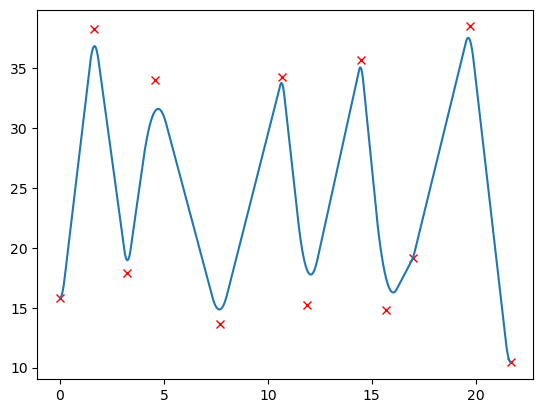

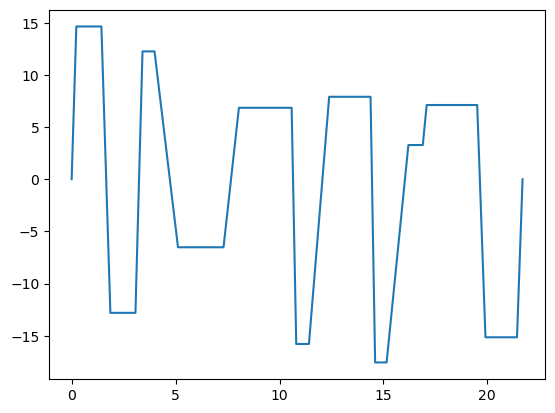

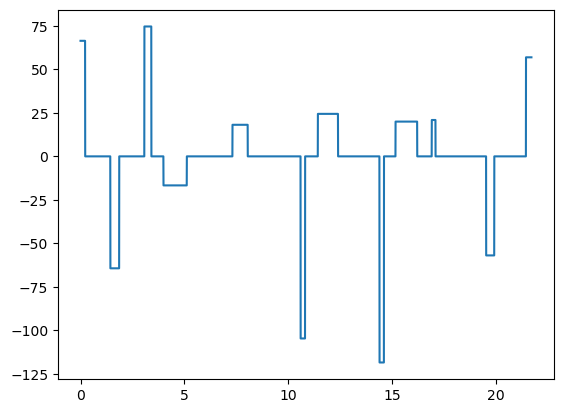

In [35]:
# Need plots for each segment:
time_history = []
disp_history = []
velo_history = []
acc_history = []
t_start = 0

# initialise starting values
disp_last = via_points[0]
velo_last = 0
for i in range(num_via_points + 1):
    t_local = np.linspace(0, tf[i], 1000)
    tb_left = t_blends[i] if i == 0 else t_blends[i]/2
    tb_right = t_blends[i+1] if i == num_via_points else t_blends[i+1]/2
    disp, velo, acc = calc_parabolic_traj_via_points(t_local, disp_last, velo_last, 
                                                                       V_vals[i], a_vals[i],
                                                                       a_vals[i+1], tb_left, tb_right)
    # use last points as the initial points for the next segment
    disp_last = disp[-1]
    velo_last = velo[-1]
    
    time_history.extend((t_local + t_start).tolist())
    
    disp_history.extend(disp.tolist())
    velo_history.extend(velo.tolist())
    acc_history.extend(acc.tolist())
    
    plt.plot(t_start, via_points[i], 'rx')
    t_start += tf[i]
    
plt.plot(t_start, via_points[-1], 'rx')
plt.plot(time_history, disp_history)
plt.show()

plt.plot(time_history, velo_history)
plt.show()

plt.plot(time_history, acc_history)
plt.show()



In [10]:

print('V_vals', V_vals)

V_vals [-2.35282689 -8.27344727  2.09064758  0.26474162  6.90298444  3.22087546
 -6.46304951 19.61393556  2.02371307 -9.11448948  6.37359633]
